In [1]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, load_from_disk
from sklearn.metrics import classification_report

tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")
aug_regex = re.compile(r"<aug>(.*?)</aug>", re.DOTALL)

/home/kyobrien/conda/envs/icdt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

inference_logs = load_from_disk("data/combined_dataset")
inference_logs.keys()

dict_keys(['BOSS_Sentiment_ID_BERT_Insert', 'BOSS_Sentiment_ID_BERT_ICR', 'BOSS_Sentiment_ID_T5_Insert', 'BOSS_Sentiment_ID_T5_Substitute', 'BOSS_Sentiment_ID_T5_Translate', 'BOSS_Sentiment_ID_Falcon_Insert', 'BOSS_Sentiment_ID_Falcon_Substitute', 'BOSS_Sentiment_ID_Falcon_Translate', 'BOSS_Sentiment_SST5_BERT_Insert', 'BOSS_Sentiment_SST5_BERT_Substitute', 'BOSS_Sentiment_SST5_BERT_Translate', 'BOSS_Sentiment_SST5_BERT_Paraphrase', 'BOSS_Sentiment_SST5_BERT_ICR', 'BOSS_Sentiment_SST5_T5_Insert', 'BOSS_Sentiment_SST5_T5_Substitute', 'BOSS_Sentiment_SST5_T5_Translate', 'BOSS_Sentiment_SST5_T5_Paraphrase', 'BOSS_Sentiment_SST5_T5_ICR', 'BOSS_Sentiment_SST5_Falcon_Insert', 'BOSS_Sentiment_SST5_Falcon_Substitute', 'BOSS_Sentiment_SST5_Falcon_Translate', 'BOSS_Sentiment_SST5_Falcon_Paraphrase', 'BOSS_Sentiment_SST5_Falcon_ICR', 'BOSS_Sentiment_SemEval_BERT_Insert', 'BOSS_Sentiment_SemEval_BERT_Substitute', 'BOSS_Sentiment_SemEval_BERT_Translate', 'BOSS_Sentiment_SemEval_BERT_Paraphrase', 'B

In [3]:
sst5_data = inference_logs["BOSS_Sentiment_SST5_BERT_ICR"].to_pandas()
display(sst5_data.head(1))
display(sst5_data.shape)

toxigen_data = inference_logs["BOSS_Toxicity_Toxigen_BERT_ICR"].to_pandas()
display(toxigen_data.head(1))
display(toxigen_data.shape)

agt_data = inference_logs["AgNewsTweets_Tweets_BERT_ICR"].to_pandas()
display(agt_data.head(1))
display(agt_data.shape)

,outcome,original_text,augmentations,original_predicted_class,tta_predicted_class,label,tta_inference_latency,original_prediction_entropy,tta_prediction_entropy,prediction_entropy_decreased,prediction_entropy_decrease,tta_mean_class_probs,tta_all_class_probs,tta_all_class_entropy
0,New Mistake,Too much of this well-acted but dangerously sl...,"[The movie, while well-acted, moves at a slow ...",0,2,0,15.558138,0.683401,0.43959,True,0.243811,"[0.14294172823429108, 0.0047321743331849575, 0...","[[0.017056243494153023, 0.008808363229036331, ...","[0.13664887845516205, 0.35321366786956787, 0.1..."


(1072, 14)

,outcome,original_text,augmentations,original_predicted_class,tta_predicted_class,label,tta_inference_latency,original_prediction_entropy,tta_prediction_entropy,prediction_entropy_decreased,prediction_entropy_decrease,tta_mean_class_probs,tta_all_class_probs,tta_all_class_entropy
0,Unfixed Mistake,While some members of congress take principle...,[While some members of Congress maintain stron...,0,0,1,16.93677,0.000069,0.000072,False,-0.000003,"[0.9999945163726807, 5.464115020004101e-06]","[[0.9999943971633911, 5.54634152649669e-06], [...","[7.272671064129099e-05, 6.922199827386066e-05,..."


(944, 14)

,outcome,original_text,augmentations,original_predicted_class,tta_predicted_class,label,tta_inference_latency,original_prediction_entropy,tta_prediction_entropy,prediction_entropy_decreased,prediction_entropy_decrease,tta_mean_class_probs,tta_all_class_probs,tta_all_class_entropy
0,Unchanged Correct,"""Just in: Afghanistan suspends vote counting &...","[Paraphrased Text Paraphrased Text, Afghanist...",0,0,0,1.301055,0.000425,0.00224,False,-0.001815,"[0.9997696280479431, 9.805682566366158e-06, 9....","[[1.7900685634231195e-05, 1.1557227708181017e-...","[0.0002792787563521415, 0.00011301380436634645..."


(7600, 14)

## Analyze ICR Generations

In [4]:
sst5_data["augmentations"].values[0]

array(['The movie, while well-acted, moves at a slow pace and feels like a prelude to a more complex and engaging story that never materializes.',
       'The movie had well-acted scenes but felt slow and like a prelude to a more complex story that never materialized.',
       'The film is well-acted but moves at a slow pace, making it feel like a prelude to a more complex story that never materializes.',
       'The thriller, although well-acted, moves at a slow pace and feels like a prelude to a more substantial and complex story that never materializes.'],
      dtype=object)

## Does TTA Effect Some Classes More Than Others?

In [5]:
sst5_data.value_counts(["label", "outcome"]).sort_index()

label  outcome          
0      NA                    10
       New Correct           29
       New Mistake            9
       Unchanged Correct    166
       Unfixed Mistake       68
1      NA                     1
       New Correct           24
       New Mistake            9
       Unchanged Correct    339
       Unfixed Mistake       27
2      NA                     9
       New Correct           46
       New Mistake           22
       Unchanged Correct    189
       Unfixed Mistake      124
Name: count, dtype: int64

In [6]:
# get the overall ratio of New Corrections to New Mistakes for sst5_data, toxigen_data, and agt_data
pd.concat([sst5_data, toxigen_data, agt_data]).value_counts(["outcome"]).sort_index()

outcome          
NA                     42
New Correct           296
New Mistake           156
Unchanged Correct    7939
Unfixed Mistake      1183
Name: count, dtype: int64

In [7]:
# for each dataset, get the percent of examples that are unchanged vs new
sst5_outcomes = sst5_data["outcome"].value_counts(normalize=True)
new_predcitions_percent = 100 * sst5_outcomes[sst5_outcomes.index == "New Correct"].values[0] + sst5_outcomes[sst5_outcomes.index == "New Mistake"].values[0]
print(f"SST-5: {new_predcitions_percent:.2f}% of examples are new predictions")

toxicgen_outcomes = toxigen_data["outcome"].value_counts(normalize=True)
new_predcitions_percent = 100 * toxicgen_outcomes[toxicgen_outcomes.index == "New Correct"].values[0] + toxicgen_outcomes[toxicgen_outcomes.index == "New Mistake"].values[0]
print(f"ToxicGen: {new_predcitions_percent:.2f}% of examples are new predictions")

agt_outcomes = agt_data["outcome"].value_counts(normalize=True)
new_predcitions_percent = 100 * agt_outcomes[agt_outcomes.index == "New Correct"].values[0] + agt_outcomes[agt_outcomes.index == "New Mistake"].values[0]
print(f"AGT: {new_predcitions_percent:.2f}% of examples are new predictions")

SST-5: 9.27% of examples are new predictions
ToxicGen: 5.04% of examples are new predictions
AGT: 1.98% of examples are new predictions


/tmp/ipykernel_369944/972366342.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst5_corruptions_corrections.sort_values(by=["label", "outcome"], inplace=True)
/tmp/ipykernel_369944/972366342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst5_corruptions_corrections["label"] = sst5_corruptions_corrections["label"].apply(lambda l: sst5_labels[l])
/tmp/ipykernel_369944/972366342.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

<Figure size 640x480 with 0 Axes>

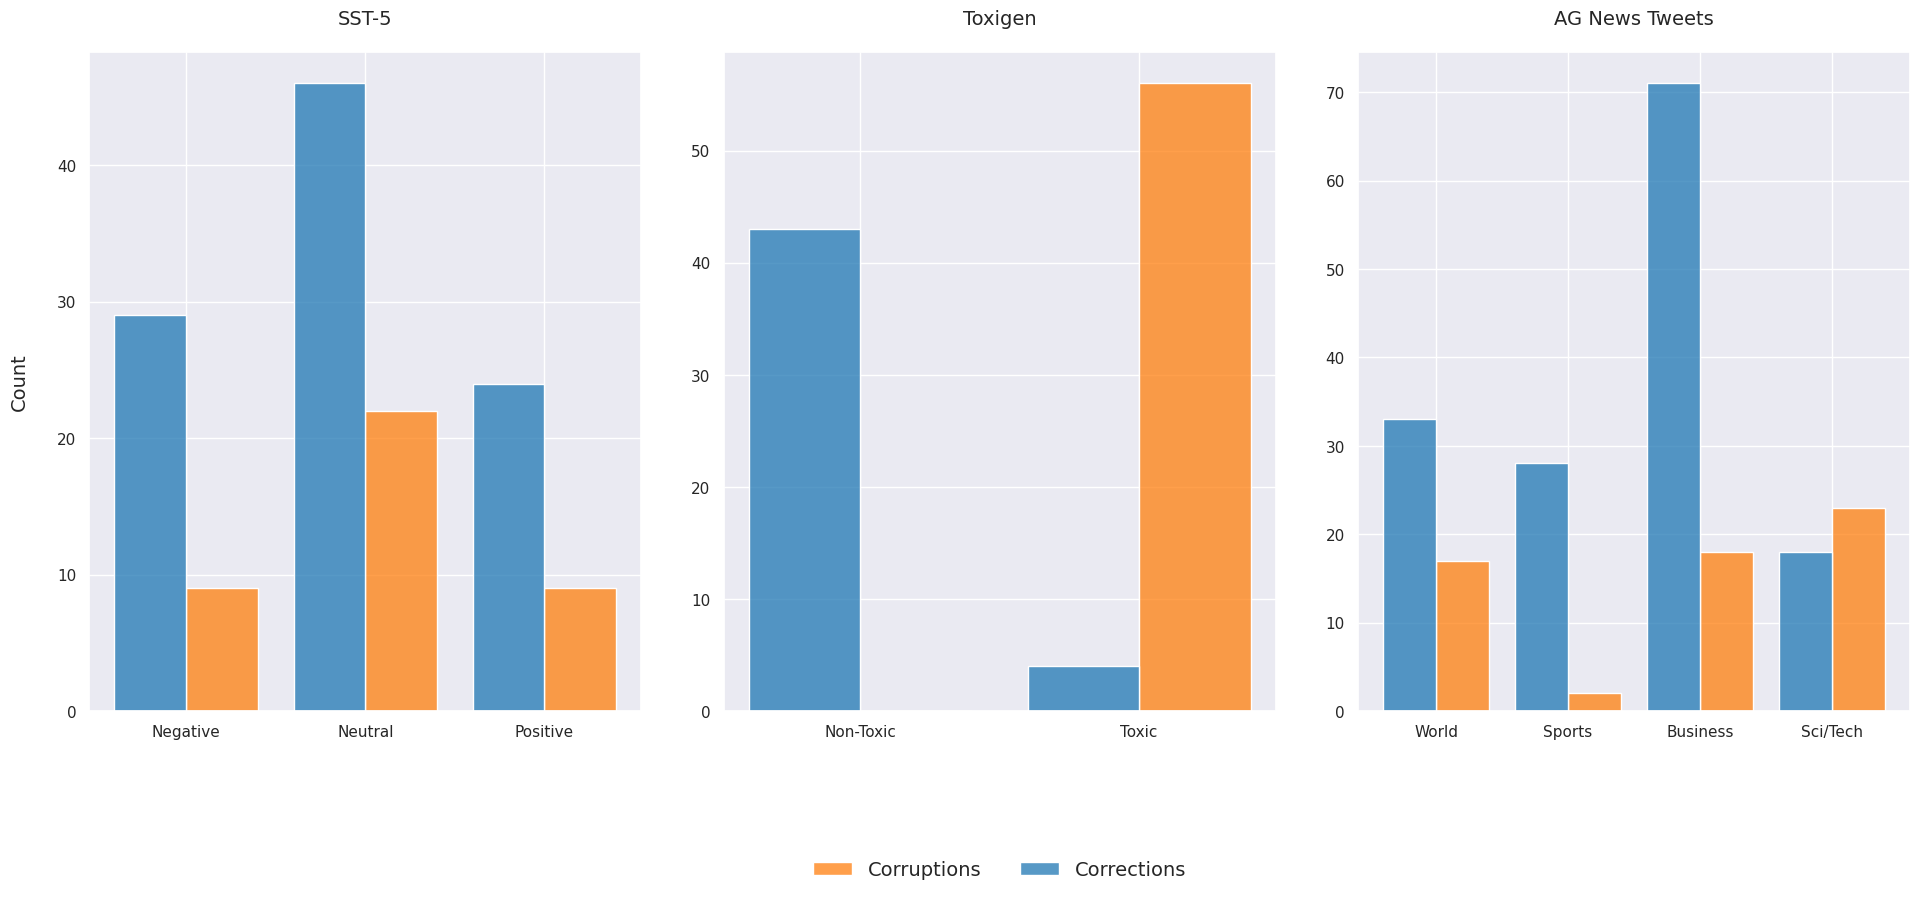

In [8]:
# clear plots
plt.clf()

# Create three histograms on one row
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

sst5_labels = {
    0: "Negative",
    1: "Positive",
    2: "Neutral",
}
sst5_corruptions_corrections = sst5_data[(sst5_data["outcome"] == "New Correct") | (sst5_data["outcome"] == "New Mistake")]
sst5_corruptions_corrections.sort_values(by=["label", "outcome"], inplace=True)
sst5_corruptions_corrections["label"] = sst5_corruptions_corrections["label"].apply(lambda l: sst5_labels[l])
# sort values by Negative, Neutral, Positive in that order
sst5_corruptions_corrections.sort_values(by=["label"], inplace=True, key=lambda x: x.map({"Negative": 0, "Neutral": 1, "Positive": 2}))
sns.histplot(data=sst5_corruptions_corrections, x="label", hue="outcome", multiple="dodge", shrink=.8, ax=axes[0])

toxigen_labels = {
    0: "Non-Toxic",
    1: "Toxic",
}
toxigen_corruptions_corrections = toxigen_data[(toxigen_data["outcome"] == "New Correct") | (toxigen_data["outcome"] == "New Mistake")]
toxigen_corruptions_corrections.sort_values(by=["label", "outcome"], inplace=True)
toxigen_corruptions_corrections["label"] = toxigen_corruptions_corrections["label"].apply(lambda l: toxigen_labels[l])
sns.histplot(data=toxigen_corruptions_corrections, x="label", hue="outcome", multiple="dodge", shrink=.8, ax=axes[1])

agt_labels = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
agt_corruptions_corrections = agt_data[(agt_data["outcome"] == "New Correct") | (agt_data["outcome"] == "New Mistake")]
agt_corruptions_corrections.sort_values(by=["label", "outcome"], inplace=True)
agt_corruptions_corrections["label"] = agt_corruptions_corrections["label"].apply(lambda l: agt_labels[l])
sns.histplot(data=agt_corruptions_corrections, x="label", hue="outcome", multiple="dodge", shrink=.8, ax=axes[2])

axes[0].set_ylabel("Count", labelpad=20, fontsize=14)
axes[1].set_ylabel("")
axes[2].set_ylabel("")
axes[0].set_xlabel("SST-5", labelpad=20, fontsize=14)
axes[1].set_xlabel("Toxigen", labelpad=20, fontsize=14)
axes[2].set_xlabel("AG News Tweets", labelpad=20, fontsize=14)

# set x labels above the plots
axes[0].xaxis.set_label_position('top')
axes[1].xaxis.set_label_position('top')
axes[2].xaxis.set_label_position('top')

# Have a shared legend
axes[0].get_legend().remove()
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), labels=["Corruptions", "Corrections"], ncol=2, fancybox=False, frameon=False, fontsize=14)
axes[2].get_legend().remove()


# add padding
fig.tight_layout(pad=3.0)
fig.savefig("../datasets/analysis/figures/corruptions_corrections_histograms.png", bbox_inches='tight', dpi=300)



## Heatmap Correlations

In [83]:
# API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
from scipy.stats import pearsonr as pearson_correlation

# API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
from scipy.stats import spearmanr as spearman_correlation

from scipy.stats import pointbiserialr

# Paper - https://arxiv.org/abs/1909.10140
# API - https://swarnakumar.github.io/xicorpy/xi/
# from xicorpy import compute_xi_correlation as xi_correlation

from sklearn import preprocessing

conditional_test_outputs = dict()

outcome_map = {
        "New Correct": 3,
        "New Mistake": 2,
        "Unchanged Correct": 1,
        "Unfixed Mistake": 0,
        "NA": None
    }
reverse_outcome_map = {v: k for k, v in outcome_map.items()}

for split in ["BOSS_Sentiment_ID_BERT_ICR", "BOSS_Sentiment_SST5_BERT_ICR"]:
    correlation_records = []

    for outcome in outcome_map.values():
        if outcome is None:
            continue
        for correlation_metric in ["original_prediction_entropy", "tta_prediction_entropy", "prediction_entropy_decrease"]:
            study_frame = inference_logs[split].to_pandas()
            study_frame["outcome"] = study_frame["outcome"].apply(lambda o: int(outcome_map[o] == outcome))
            study_frame.dropna(inplace=True)
            correlation_results = pointbiserialr(study_frame[correlation_metric], study_frame["outcome"])
            correlation_records.append({
                "outcome": reverse_outcome_map[outcome],
                f"{correlation_metric}_correlation": correlation_results[0],
                f"{correlation_metric}_p-value": correlation_results[1],
            })

    print(f"Split: {split}")
    display(pd.DataFrame(correlation_records).groupby("outcome").mean())


Split: BOSS_Sentiment_ID_BERT_ICR


,original_prediction_entropy_correlation,original_prediction_entropy_p-value,tta_prediction_entropy_correlation,tta_prediction_entropy_p-value,prediction_entropy_decrease_correlation,prediction_entropy_decrease_p-value
outcome,,,,,,
New Correct,0.320918,0.0,0.315037,0.0,0.007230,1.539703e-01
New Mistake,0.208196,0.0,0.294874,0.0,-0.154156,2.285083e-205
Unchanged Correct,-0.516980,0.0,-0.566368,0.0,0.091676,2.425015e-73
Unfixed Mistake,0.313689,0.0,0.326801,0.0,-0.026040,2.812946e-07


Split: BOSS_Sentiment_SST5_BERT_ICR


,original_prediction_entropy_correlation,original_prediction_entropy_p-value,tta_prediction_entropy_correlation,tta_prediction_entropy_p-value,prediction_entropy_decrease_correlation,prediction_entropy_decrease_p-value
outcome,,,,,,
New Correct,0.280441,7.990941e-21,0.328018,2.621138e-28,-0.061719,0.043350
New Mistake,0.212347,2.145317e-12,0.187790,5.771866e-10,0.046494,0.128182
Unchanged Correct,-0.442123,1.600855e-52,-0.540031,3.480684e-82,0.132545,0.000013
Unfixed Mistake,0.173677,1.044429e-08,0.253155,3.880296e-17,-0.115186,0.000157


## Calculate Optimal ID Entropy Thresholds

In [31]:
def get_entropy_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if row["tta_prediction_entropy"] > threshold else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = (inference_logs_frame["original_prediction_entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate

In [32]:
optimal_entropy_thresholds = {}
thresholds = np.arange(0.1, 1, 0.1)
for split in [dataset for dataset in inference_logs if "ID_BERT_ICR" in dataset]:
    best_threshold = None
    for threshold in tqdm(thresholds):
        accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, inference_logs[split].to_pandas())
        if best_threshold is None or accuracy > best_threshold["accuracy"]:
            best_threshold = {
                "threshold": threshold,
                "accuracy": accuracy,
                "llm_call_rate": f"{llm_call_rate:.2f}%",
            }

    optimal_entropy_thresholds[split] = best_threshold
    print(f"{split}: {best_threshold}")



100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


BOSS_Sentiment_ID_BERT_ICR: {'threshold': 0.1, 'accuracy': 0.908955377339091, 'llm_call_rate': '0.52%'}


100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


BOSS_Toxicity_ID_BERT_ICR: {'threshold': 0.1, 'accuracy': 0.9032675709001233, 'llm_call_rate': '0.02%'}


100%|██████████| 9/9 [00:00<00:00, 10.77it/s]

AgNewsTweets_ID_BERT_ICR: {'threshold': 0.7000000000000001, 'accuracy': 0.9481578947368421, 'llm_call_rate': '0.00%'}


## Class Based Selective Augmentation

In [36]:
def combined_selective_augment(row, entropy_threshold, responsive_classes):
    if row["original_prediction_entropy"] > entropy_threshold and row["original_predicted_class"] in responsive_classes:
        return row["tta_predicted_class"]
    return row["original_predicted_class"]

    # if row["original_prediction_entropy"] > entropy_threshold:
    #     return row["tta_predicted_class"]
    # if row["original_predicted_class"] in responsive_classes:
    #     return row["tta_predicted_class"]
    # return row["original_predicted_class"]


model = "BERT"
id_icr_logs = [split for split in inference_logs if f"ID_{model}_ICR" in split]
ood_icr_reports = [split for split in inference_logs if f"{model}_ICR" in split and f"ID_{model}_ICR" not in split]
perf_records = []

# display(id_icr_logs)
# display(ood_icr_reports)
for id_icr_split in id_icr_logs:
    # print(f"{id_icr_split}:")
    id_icr_data = inference_logs[id_icr_split].to_pandas()
    change_predictions_count_by_label = id_icr_data[id_icr_data["outcome"].str.contains("New")].value_counts(["label", "outcome"]).sort_index()

    # get list of labels where New Correct > New Mistake
    labels_list = []
    for label in change_predictions_count_by_label.index.levels[0]:
        new_correct_count = change_predictions_count_by_label.loc[label].values[0]
        new_mistake_count = change_predictions_count_by_label.loc[label].values[1]
        if new_correct_count > 1 * new_mistake_count:
            labels_list.append(label)

    # display(change_predictions_count_by_label)
    # display(labels_list)

    # print("Baseline Report")
    # print(classification_report(id_icr_data["label"], id_icr_data["tta_predicted_class"], digits=4, zero_division=0))
    perf_records.append({
        "split": id_icr_split,
        "selective augmentation": None,
        "accuracy": classification_report(id_icr_data["label"], id_icr_data["tta_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    # print("Only Augment Response Label Report")
    selective_predictions = id_icr_data.apply(lambda row: row["tta_predicted_class"] if row["label"] in labels_list else row["original_predicted_class"], axis=1)
    # print(classification_report(id_icr_data["label"], selective_predictions, digits=4, zero_division=0))
    perf_records.append({
        "split": id_icr_split,
        "selective augmentation": "class-based",
        "accuracy": classification_report(id_icr_data["label"], selective_predictions, digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    # print("Evlauate on OOD Shifts")
    for ood_icr_report in [shift for shift in ood_icr_reports if id_icr_split[:10] in shift]:
        ood_icr_data = inference_logs[ood_icr_report].to_pandas()
        # print(f"{ood_icr_report} TTA Baseline:")
        # print(classification_report(ood_icr_data["label"], ood_icr_data["tta_predicted_class"], digits=4, zero_division=0))
        perf_records.append({
            "split": ood_icr_report,
            "selective augmentation": None,
            "accuracy": classification_report(ood_icr_data["label"], ood_icr_data["tta_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
        })

        # print(f"{ood_icr_report} Selective Augment: Class-based:")
        selective_predictions = ood_icr_data.apply(lambda row: row["tta_predicted_class"] if row["original_predicted_class"] in labels_list else row["original_predicted_class"], axis=1)
        # print(classification_report(ood_icr_data["label"], selective_predictions, digits=4, zero_division=0))
        perf_records.append({
            "split": ood_icr_report,
            "selective augmentation": "class-based",
            "accuracy": classification_report(ood_icr_data["label"], selective_predictions, digits=4, zero_division=0, output_dict=True)["accuracy"],
        })

        # print(f"{ood_icr_report} Selective Augment: Entropy-based")
        optimal_entropy_threshold = optimal_entropy_thresholds[id_icr_split]["threshold"]
        accuracy = get_entropy_threshold_accuracy(optimal_entropy_threshold, ood_icr_data)[0]
        perf_records.append({
            "split": ood_icr_report,
            "selective augmentation": "entropy-based",
            "accuracy": accuracy,
        })

        # print(f"{ood_icr_report} Selective Augment: Class-based & Entropy-based")
        selective_predictions = ood_icr_data.apply(lambda row: combined_selective_augment(row, optimal_entropy_threshold, labels_list), axis=1)
        # print(classification_report(ood_icr_data["label"], selective_predictions, digits=4, zero_division=0))
        perf_records.append({
            "split": ood_icr_report,
            "selective augmentation": "class-based or entropy-based",
            "accuracy": classification_report(ood_icr_data["label"], selective_predictions, digits=4, zero_division=0, output_dict=True)["accuracy"],
        })


pd.DataFrame(perf_records)

,split,selective augmentation,accuracy
0,BOSS_Sentiment_ID_BERT_ICR,None,0.908518
1,BOSS_Sentiment_ID_BERT_ICR,class-based,0.908518
2,BOSS_Sentiment_SST5_BERT_ICR,None,0.739739
3,BOSS_Sentiment_SST5_BERT_ICR,class-based,0.739739
4,BOSS_Sentiment_SST5_BERT_ICR,entropy-based,0.739739
5,BOSS_Sentiment_SST5_BERT_ICR,class-based or entropy-based,0.739739
6,BOSS_Sentiment_SemEval_BERT_ICR,None,0.490497
7,BOSS_Sentiment_SemEval_BERT_ICR,class-based,0.490497
8,BOSS_Sentiment_SemEval_BERT_ICR,entropy-based,0.490497
9,BOSS_Sentiment_SemEval_BERT_ICR,class-based or entropy-based,0.490497


# Entropy-Based Selective Augmentation# Entropy Analysis

## Entropy Accuracy Curves

## Entropy Accuracy Curves

In [ ]:
thresholds = np.arange(0, 1, 0.01)
# thresholds = np.arange(0, 1, 0.05)

baseline_perf = {
    "SST-5": 0.6847,
    "Sem Eval": 0.4498,
    "Dynasent": 0.4271,
    "ToxiGen": 0.6670,
    "Adv Civil": 0.3050,
    "Implicit Hate": 0.6454,
    "AG News Tweets": 0.8857,
}

In [ ]:
# create a fix where each plot is 5 inches wide and 5 inches tall with 2 padding
fig, axs = plt.subplots(ncols=3, figsize=(15, 6))

def calculate_entropy_threshold_jugments(inference_log_frame, dataset_name, half=False):
    threshold_scores = []
    threshold_rewrite_rates = []
    for t in tqdm(thresholds, desc="Calculating entropy threshold scores"):
        t_perf, t_rate = get_threshold_accuracy(t, inference_log_frame)
        threshold_scores.append(t_perf)
        threshold_rewrite_rates.append(t_rate)

    thresholds_frame = pd.DataFrame({"threshold": thresholds, "accuracy": threshold_scores, "rewrite_rate": threshold_rewrite_rates})

    # Set line splot
    coordinates = {
        "SST-5": 0,
        "ToxiGen": 1,
        "AG News Tweets": 2,
    }

    # Create a line plot with the coordinates in the grid
    figure = axs[coordinates[dataset_name]]
    figure = sns.lineplot(data=thresholds_frame, x="rewrite_rate", y="accuracy", label="TTA", ax=figure)
    figure.set_title(dataset_name, fontsize=18, pad=15)
    figure.set_xlabel("Augmentation Rate" if dataset_name == "ToxiGen" else "", labelpad=20, fontsize=14)
    figure.set_ylabel("Accuracy" if dataset_name == "SST-5" else "", labelpad=20, fontsize=14)
    figure.title.set_size(18)
    figure.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
    figure.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
    figure.set_xlim(left=0)
    figure.lines[0].set_linewidth(2)
    figure.legend_.remove()

    # Display max accuracy point
    accuracy_max_point = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1].to_dict()
    figure.plot(accuracy_max_point["rewrite_rate"],
                accuracy_max_point["accuracy"],
                marker="o",
                markersize=6,
                label="Optimal",
                )
    figure.annotate(f"{accuracy_max_point['accuracy']:.2%}",
                    (accuracy_max_point["rewrite_rate"], accuracy_max_point["accuracy"]),
                    textcoords="offset points",
                    xytext=(10, 0),
                    ha="left",
                    fontsize=10)

    # plot dashed gray line representing the baseline withour augmentation
    figure.plot([0, 1], [baseline_perf[dataset_name], baseline_perf[dataset_name]], color="gray", linestyle="--", linewidth=1.5, alpha=0.75, label="No TTA (Baseline)")
    # figure.axhline(baseline_perf[dataset_name], color="gray", linestyle="--", linewidth=1.5, alpha=0.75)
    if dataset_name == "SST-5":
        figure.set_ylim(bottom=baseline_perf[dataset_name] - 0.005)

    if dataset_name == "ToxiGen":
        figure.legend(loc="upper center", fontsize=12, frameon=False, ncol=3,
                      bbox_to_anchor=(0.5, -0.2),
                      )

    target_threshold = None
    if half is False:
        target_threshold = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1]
    else:
        thresholds_deltas_list = abs(thresholds_frame["rewrite_rate"] - 50).tolist()
        closest_half_delta = min(thresholds_deltas_list)
        closest_threshold_index = thresholds_deltas_list.index(closest_half_delta)
        target_threshold = thresholds_frame.iloc[closest_threshold_index]

    rewrite_rate = target_threshold["rewrite_rate"] / 100
    original_judgments = inference_log_frame.apply(lambda row: row["original_predicted_class"] if row["original_prediction_entropy"] < target_threshold["threshold"] else row["tta_predicted_class"], axis=1)
    return original_judgments, rewrite_rate


calculate_entropy_threshold_jugments(inference_logs["BOSS_Sentiment_ID_BERT_ICR"].to_pandas(), "SST-5")
calculate_entropy_threshold_jugments(inference_logs["BOSS_Toxicity_ID_BERT_ICR"].to_pandas(), "ToxiGen")
calculate_entropy_threshold_jugments(inference_logs["AgNewsTweets_ID_BERT_ICR"].to_pandas(), "AG News Tweets")
fig.tight_layout(pad=1.0)
fig.savefig("../datasets/analysis/entropy_figures/main_acc_rewrite_curves.png", bbox_inches="tight")

## Appendix Entropy Figures

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 10), nrows=2)

def calculate_entropy_threshold_jugments(inference_log_frame, dataset_name, half=False):
    # thresholds = np.arange(0, 1, 0.0001)
    threshold_scores = []
    threshold_rewrite_rates = []
    for t in tqdm(thresholds, desc="Calculating entropy threshold scores"):
        t_perf, t_rate = get_threshold_accuracy(t, inference_log_frame)
        threshold_scores.append(t_perf)
        threshold_rewrite_rates.append(t_rate)

    thresholds_frame = pd.DataFrame({"threshold": thresholds, "accuracy": threshold_scores, "rewrite_rate": threshold_rewrite_rates})

    # Set line splot
    coordinates = {
        "SST-5": (0, 0),
        "Sem Eval": (0, 1),
        "Dynasent": (0, 2),
        "ToxiGen": (0, 3),
        "Adv Civil": (1, 0),
        "Implicit Hate": (1, 1),
        "AG News Tweets": (1, 2),
    }

    # Create a line plot with the coordinates in the grid
    figure = axs[coordinates[dataset_name][0]][coordinates[dataset_name][1]]
    figure = sns.lineplot(data=thresholds_frame, x="rewrite_rate", y="accuracy", label="TTA", ax=figure)
    figure.set_title(dataset_name, fontsize=18, pad=15)
    figure.set_xlabel("Augmentation Rate" if dataset_name in ["ToxiGen", "Adv Civil", "Implicit Hate", "AG News Tweets"] else "", labelpad=20, fontsize=14)
    figure.set_ylabel("Accuracy" if dataset_name in ["SST-5", "Adv Civil"] else "", labelpad=20, fontsize=14)
    figure.title.set_size(18)
    figure.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
    figure.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
    figure.set_xlim(left=0)
    figure.lines[0].set_linewidth(2)
    figure.legend_.remove()

    # Display max accuracy point
    accuracy_max_point = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1].to_dict()
    figure.plot(accuracy_max_point["rewrite_rate"],
                accuracy_max_point["accuracy"],
                marker="o",
                markersize=6,
                label="Optimal",
                )
    figure.annotate(f"{accuracy_max_point['accuracy']:.2%}",
                    (accuracy_max_point["rewrite_rate"], accuracy_max_point["accuracy"]),
                    textcoords="offset points",
                    xytext=(10, 0),
                    ha="left",
                    fontsize=10)

    figure.plot([0, 1], [baseline_perf[dataset_name], baseline_perf[dataset_name]], color="gray", linestyle="--", linewidth=1.5, alpha=0.75, label="No TTA (Baseline)")

    if dataset_name == "SST-5":
        figure.set_ylim(bottom=baseline_perf[dataset_name] - 0.005)

    target_threshold = None
    if half is False:
        target_threshold = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1]
    else:
        thresholds_deltas_list = abs(thresholds_frame["rewrite_rate"] - 50).tolist()
        closest_half_delta = min(thresholds_deltas_list)
        closest_threshold_index = thresholds_deltas_list.index(closest_half_delta)
        target_threshold = thresholds_frame.iloc[closest_threshold_index]

    rewrite_rate = target_threshold["rewrite_rate"] / 100
    original_judgments = inference_log_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < target_threshold["threshold"] else row["judgment"], axis=1)
    return original_judgments, rewrite_rate


def get_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < threshold else row["judgment"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True)
    llm_call_count = (inference_logs_frame["original entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate


calculate_entropy_threshold_jugments(sst5_data, "SST-5")
calculate_entropy_threshold_jugments(semval_data, "Sem Eval")
calculate_entropy_threshold_jugments(dynasent_data, "Dynasent")
calculate_entropy_threshold_jugments(toxigen_data, "ToxiGen")
calculate_entropy_threshold_jugments(adv_civil_data, "Adv Civil")
calculate_entropy_threshold_jugments(implicit_hate_data, "Implicit Hate")
calculate_entropy_threshold_jugments(agt_data, "AG News Tweets")

fig.delaxes(axs[1, -1])
fig.legend(loc="lower center", fontsize=12, frameon=False, ncol=3, labels=["TTA", "No TTA (Baseline)", "Optimal Aug Rate"], bbox_to_anchor=(0.5, -0.025))
fig.tight_layout(pad=2.0)
fig.savefig("../datasets/analysis/entropy_figures/appendix_acc_rewrite_curves.png", bbox_inches="tight")

In [ ]:
sem_eval_original_entropies = semval_data["original entropy"].tolist()
figure = sns.scatterplot(data=semval_data, x=range(len(sem_eval_original_entropies)), y="original entropy", hue="outcome", s=5)
# set legend to the right vertically
figure.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, frameon=False, title="Outcome")
# make y axis log scale
figure.set_yscale("log")

In [ ]:
sst5_data[["original entropy", "outcome"]].groupby("outcome").describe()

In [ ]:
# heatmap between original entropy and outcome
pd.crosstab(sst5_data["original entropy"], semval_data["outcome"])